## 模型选择
如何选超参数  
训练误差：模型在训练数据上的误差（不关心）  
泛化误差：模型在新数据上的误差

训练数据集：训练模型参数  
验证数据集：一个用来评估模型好坏的数据集，选择模型超参数（可能虚高）  
    例如拿50%训练数据，不要跟训练数据混在一起（数据来源）  
测试数据集：只用一次的数据集（不能用来调超参数）

k-折交叉验证  
没有足够多数据时使用（常态）  
    将训练数据分成k块，用第i块做验证数据集，其余做训练数据集，报告k个验证集误差的平均  
    常用k=5或k=10（数据很多-k小一点；数据很少-k大一点。权衡用多少数据训练以及能承受多少倍的训练代价）

## 过拟合和欠拟合
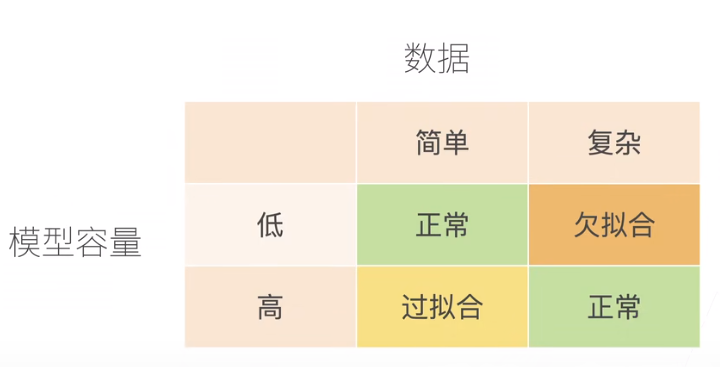

欠拟合：精度不好  
过拟合：泛化能力不好

模型容量：拟合各种函数的能力  
低容量的模型难以拟合训练数据  
高容量的模型可以记住所有的训练数据

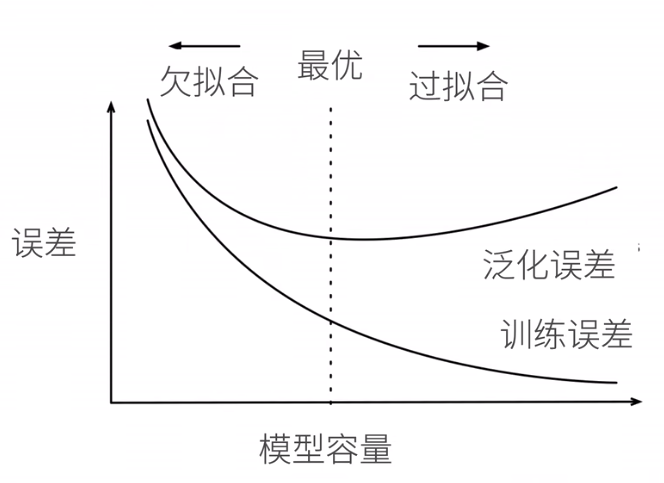

核心任务：
1. 泛化误差最优点往下拉
2. 减小训练误差与泛化误差的差值

有时为了将泛化误差往下降，不得不过拟合，模型容量得够，控制容量--深度学习的核心

估计模型容量  
难以在不同种类的算法之间比较（树模型和神经网络）  
给定一个模型种类，有两个主要因素：  
1. 参数个数  
2. 参数值的选择范围

VC维  
统计学习理论的一个核心思想  
对于一个分类模型，VC等于一个最大的数据集的大小，不管如何给定标号，都存在一个模型对它进行完美分类。  
--模型复杂度等价于模型能够完美记住一个数据集，该数据集最大能有多大

线性分类器的VC维  
2维输入的感知机（2，1）：VC维=3  
支持N维输入的感知机的VC维是N+1  
一些多层感知机的VC维：O(NlogN)

VC维提供一个模型为什么好的理论依据--可以衡量训练误差和泛化误差之间的间隔  
但深度学习中很少使用--衡量不准确，计算深度学习模型的VC维很困难

数据复杂度  
多个重要因素：
* 样本个数
* 每个样本的元素个数
* 时间、空间结构
* 多样性（类别数）

代码

**模型和数据匹配**  
训练和测试最后的精度差不多  
训练和测试之间的gap小

**欠拟合**  
最后的损失大

**过拟合**  
测试误差过了最低点后往上升  
最后训练和测试之间的gap大

QA

## 权重衰退
处理过拟合

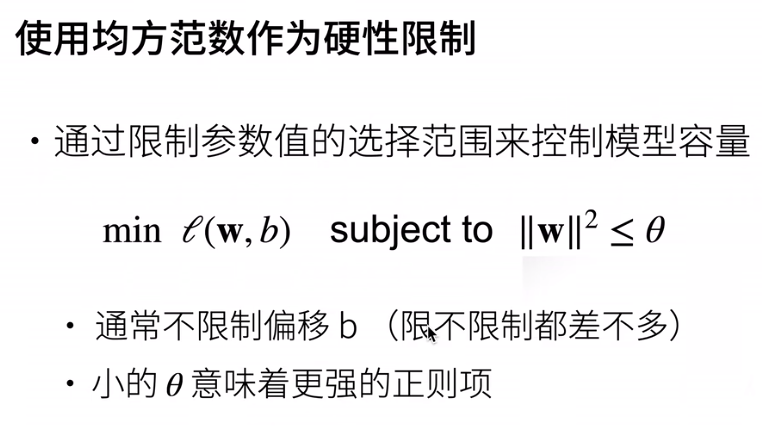

常用：

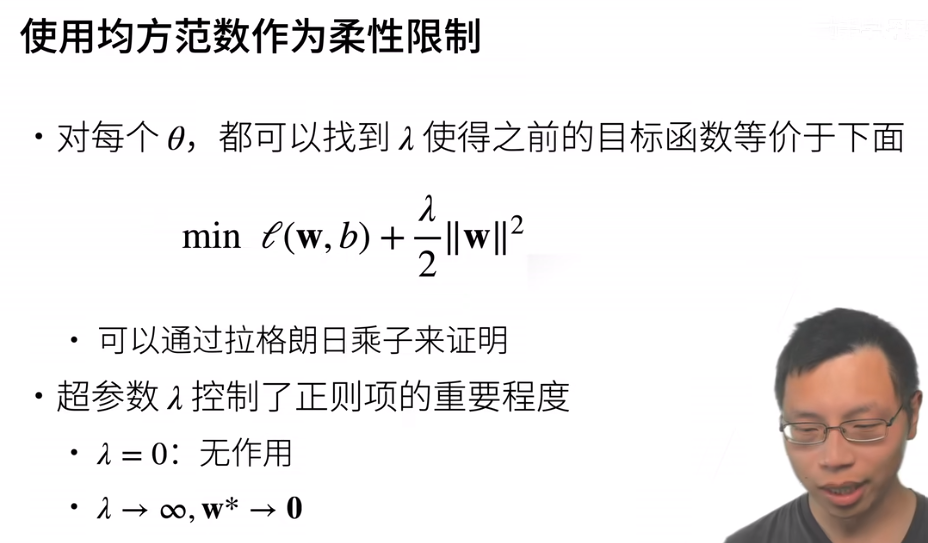

通过增大λ控制模型复杂度  
w最终到达一个平衡点  
阀的引入使最优解往原点走，绝对值小，整个模型复杂度低

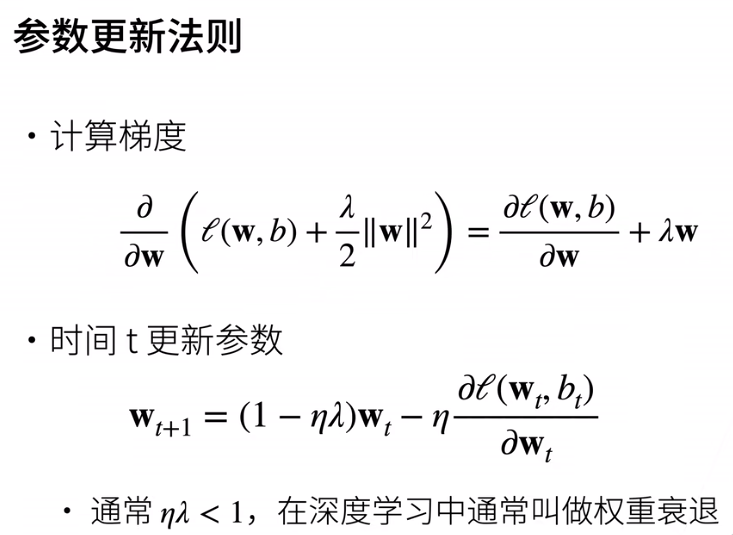

wt+1 = wt - η*梯度

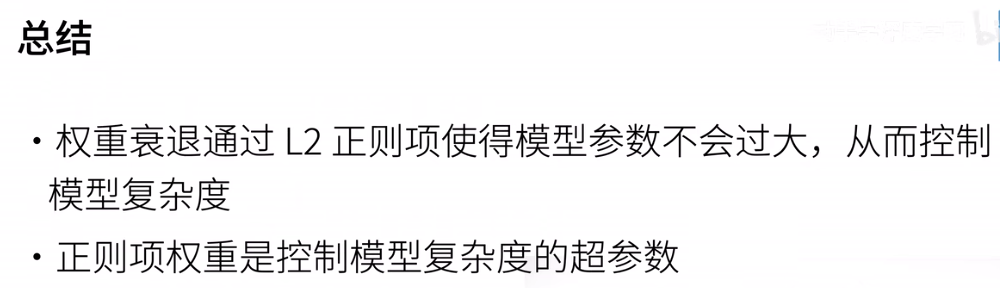

## 代码
权重衰减是最广泛使用的正则化技术之一

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

生成人工数据集，可以更清晰地看见与真实之间的区别

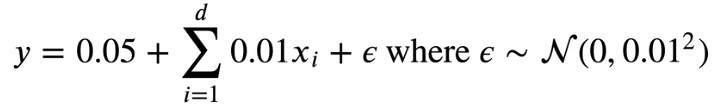

线性回归问题  
偏差0.05，权重0.01，输入x，噪音epsilon

In [ ]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [ ]:
# 初始化模型参数
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

# 定义L2范数惩罚
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2  # L2平方范数

In [ ]:
# 训练
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss  # 线性回归，平方损失函数
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
    xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # with torch.enable_grad():
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                    d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())


In [ ]:
# 忽略正则化直接训练
train(lambd=0)
# 训练损失一直在降，测试基本是平的--过拟合

# 使用权重衰减
train(lambd=3)
# 测试在往下降，迭代50轮后训练平，过拟合不会再往下走
# 可以多迭代轮数，或lambda调大

In [ ]:
# 简洁实现
def train_concise(wd): # lambd
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([{"params":net[0].weight,'weight_decay': wd},
                            {"params":net[0].bias}], lr=lr)  # 阀既可以写在目标函数里面，也可以做在训练算法里面（更新之间w乘以一个小值）
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                    d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

In [ ]:
train_concise(0)

train_concise(3)

# 通常选择1e-3等

QA

## 丢弃法dropout
可能比权重衰退效果更好

一个好的模型需要对输入数据的扰动鲁棒  
使用有噪音的数据等价于Tikhonov正则（正则：使权重不要特别大，避免过拟合）  
丢弃法：在层之间加入噪音  
随机噪音，不在输入中

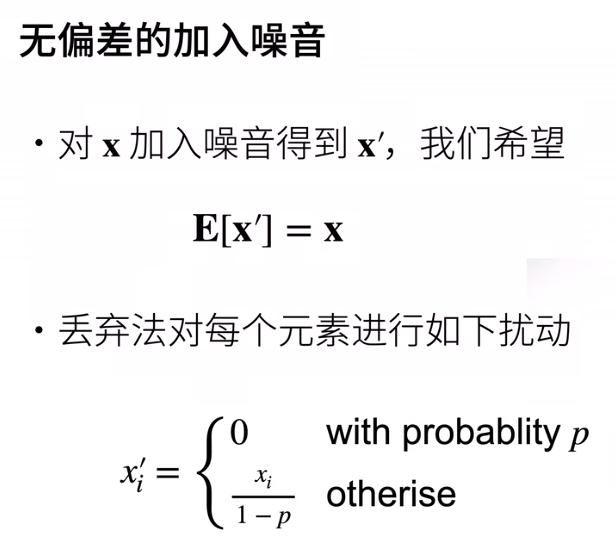

x是输出，希望加噪音后期望不变  
E[x'i] = p * 0 + (1-p)*xi / (1-p) = xi

通常将丢弃法作用在隐藏全连接层的输出上

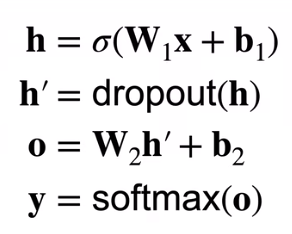

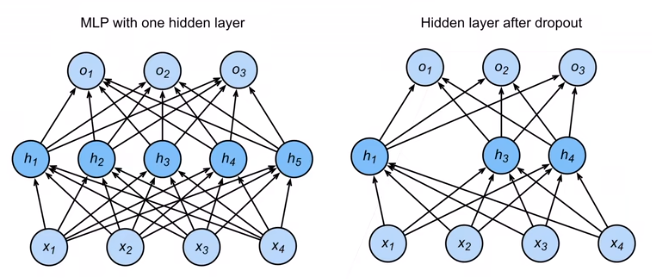

h：第一个隐藏层的输出

正则项只在训练中使用，影响模型参数的更新  
推理中丢弃法直接返回输入 h = dropout(h)  
这样也能保证确定性的输出

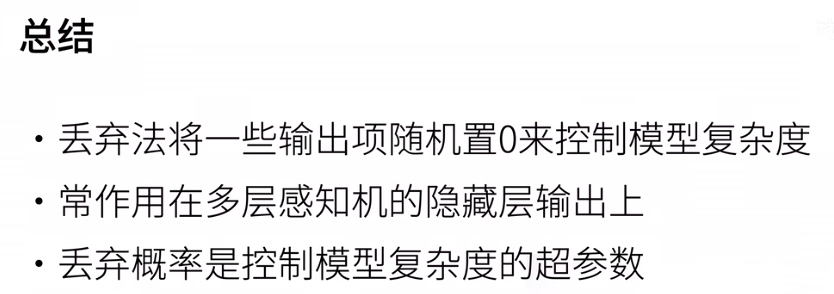

p一般取0.5 0.9 0.1

dropout是最主流的一个对多层感知机模型控制的方法  
对深度学习，通常可以将模型弄得复杂一点，再通过正则化控制模型复杂度--可以将隐藏层设大，dropout也设大

## 代码实现

In [ ]:
# 实现dropout_layer函数，该函数以dropout的概率丢弃张量输入x中的元素
import torch
from torch import nn
from d2l import torch as d2l


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    # mask哪些要变成0。生成0-1之间均匀随机分布，如果大于dropout，选出等于1，否则等于0
    mask = (torch.rand(X.shape) > dropout).float()   # rand/randn
    # X[mask] = 0 对GPU和CPU都不友好，做乘法远远比选元素快
    return mask * X / (1.0- dropout)

In [ ]:
# 测试dropout_layer函数
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

In [ ]:
# 定义有两个隐藏层的多层感知机，每个隐藏层256个单元
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)   # 隐藏层1
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)  # 隐藏层2
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)  # 输出层
        self.relu = nn.ReLU()
    
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out
    

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

In [ ]:
# 训练和测试
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [ ]:
# 简洁实现
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 256), nn.ReLU(), nn.Dropout(dropout1),
                    nn.Linear(256, 256), nn.ReLU(), nn.Dropout(dropout2),
                    nn.Linear(256, 10))
 
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
    
net.apply(init_weights)

# 训练和测试
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

QA

## 数值稳定性
当神经网络很深时，数值很容易不稳定  

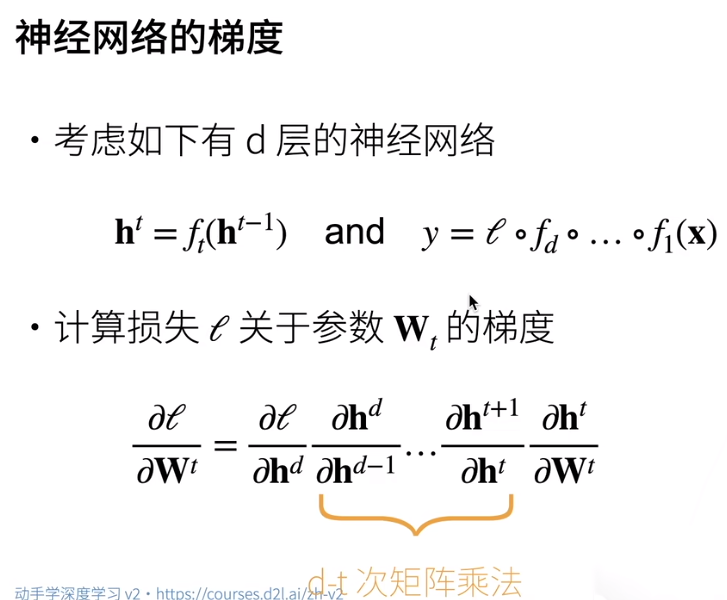

常见的两个问题：
1. 梯度爆炸
2. 梯度消失

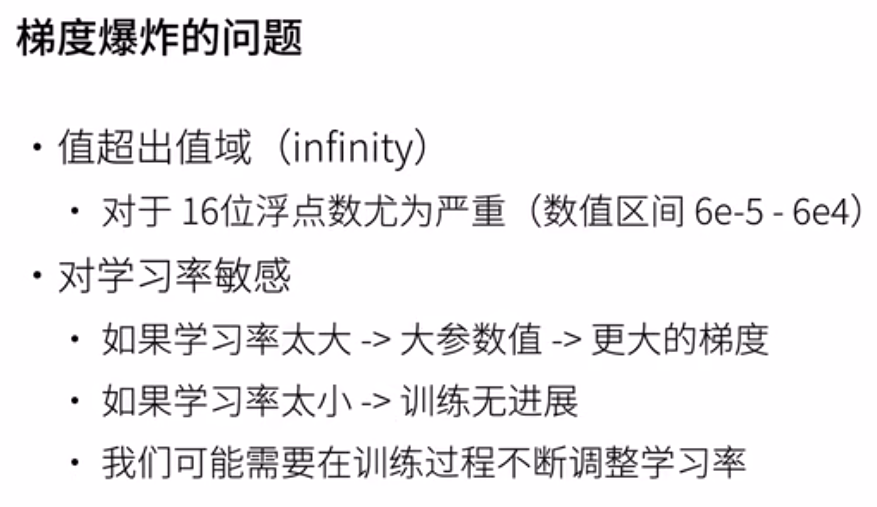

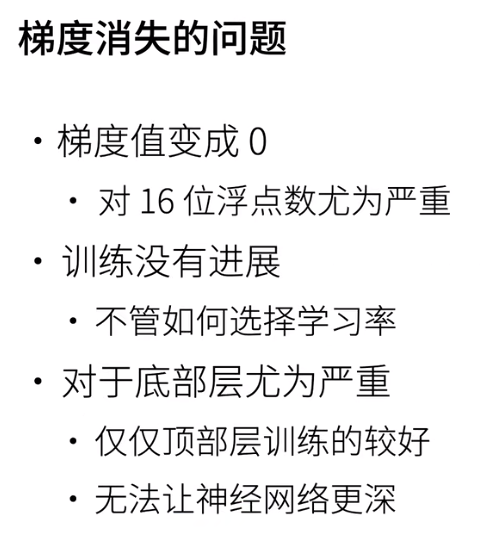

当数值过大或过小时会导致数值问题  
常发生在深度模型中--梯度就是对n个层累乘

## 模型初始化和激活函数
让训练更加稳定 
目标：让梯度值在合理的范围内
- 乘法变加法
    - ResNet LSTM
- 归一化
    - 梯度归一化 梯度裁剪
- 合理的权重初始和激活函数

让每层的方差是一个常数
* 将每层的输出和梯度都看作随机变量
* 让它们（输出和梯度）的均值（为0）和方差（固定值）都保持一致

### 权重初始化  
在合理值区间里随机初始参数  
训练开始的时候更容易有数值不稳定，远离最优解的地方损失函数表面可能很复杂，最优解附近表面会比较平
用N(0,0.01)初始可能对小网络没问题，但不能保证深度神经网络

以MLP为例
若使正向输入方差和输出方差一样 nt-1*γt=1
梯度的方差相等 nt*γt=1
nt-1 第t层输入维度
γt 第t层权重初始的方差
nt 第t层输出维度
**Xavier初始**
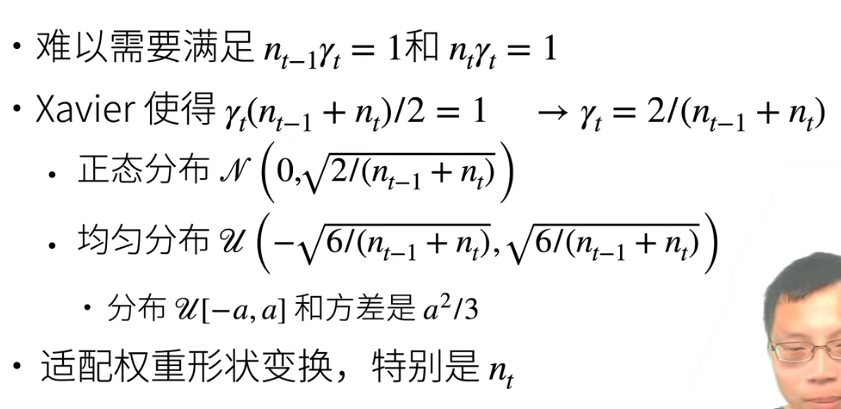
权重初始化时的方差根据输入和输出维度来定

### 激活函数
**tanh(x)** 和 **relu(x)** 在零点附近比较满足要求
sigmoid不满足
调整：**4 * sigmoid(x) - 2**

合理的权重初始值和激活函数的选取可以提升数值稳定性

QA